# Implementation for Local Regression (LOWESS, LOESS)

https://en.wikipedia.org/wiki/Local_regression

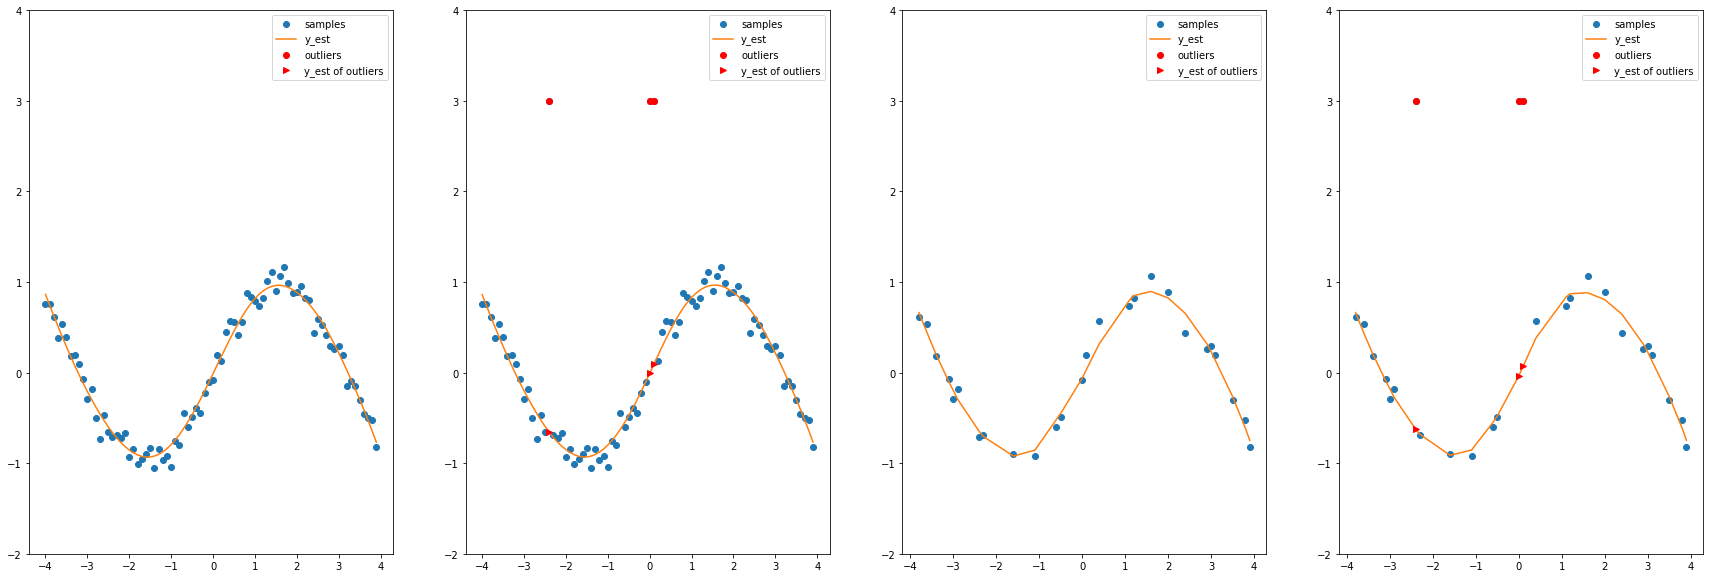

In [3]:
def poly(x, w):
    y = w[0] * np.ones(x.shape)
    for i in range(1, w.shape[0]):
        y += w[i] * x ** i
    return y

# function to fit a polynomial at each x_i once time
def loess_once(x, t, window, g, weight_matrix, M=2):
      # array to save prediction of each x_i after the fitting
      y = np.ones_like(x)
      # number of x_i (or number of data point)
      n = x.shape[0]
      # iterate over x, at each x_i -> fit a loal polynomial to x_i
      for i in range(x.shape[0]):
        # range of the nearby data points x_k used in fitting the local polynomial
        start = max(0, i-window) 
        stop = min(n, i+window+1)
        # extract x_k and t_k
        sub_x = x[start:stop] 
        sub_t = t[start:stop]

        # weights of x_k with respect to x_i
        weights = weight_matrix[i][start:stop]
        weights = weights * g[start:stop]
        # for convenience, turn the vector to diagonal matrix
        Weights = np.diag(weights)

        #local poly: quadratic or linear
        #M = 2 #1
        X = np.ones((sub_x.shape[0], M+1))
        for j in range(1, M+1):  #note: Do not use same i in here, otherwise overwrite i in outer
          X[:, j] = sub_x**j

        # parameters of the local poly
        # w = (X.T @ W @ X + Lambda*I)^-1 @ X.T @ W @ t
        Lambda = 0.01
        w = np.linalg.inv(np.transpose(X) @ Weights @ X + Lambda*np.eye(X.shape[1])) @ np.transpose(X) @ Weights @ sub_t
        
        # prediction value of x_i with the local poly
        y[i] = poly(x[i], w) 
      
      return y

def loess(x, t, ratio, iteration):
    """loess(x, t, ratio, iteration) -> y_est
    Fit local polynomials to a scatterplot (x, t).
    """
    # number of data points
    n = x.shape[0]
    # window size
    window = int(ratio*n)

    # init g_i = 1 for each i
    g = np.ones_like(x)

    # caculate d_i: Note that this is based on the assumption that x is sorted in ascending order
    d = np.ones_like(x)
    for i in range(n):
      d[i] = max(abs(x[i] - x[max(0, i-window)]), abs(x[i] - x[min(n-1, i+window)]))

    # caculate weight w_i,k
    # we dont need to calculate w_i,k for all i, k; but we do so for convenience with matrix multiplication
    # w = (1 - |diag(1/d) @ (x_1 - x_0)|^3)^3
    tmp = np.diag(1/d)@(np.expand_dims(x, 1) - np.expand_dims(x, 0))
    weight_matrix = (1 - np.absolute(tmp)**3)**3

    # iterate step 3 -> 8 iteration times
    for it in range(iteration):
      # fit a polynomial at each x_i with weight g_k * w_i,k
      # lowess: M=1; loess: M=2 or more
      y_est = loess_once(x, t, window, g, weight_matrix, M=2)
      # compute r_i
      r = np.absolute(y_est - t)
      # median of r_i
      m = np.median(r)
      # update g and reject if r_i >= 6m
      mask = r < 6*m
      g = (1 - (r/(6*m)) ** 2) ** 2 * mask

    # extract outlier for illustration
    outlier = np.where(g == 0)[0]
    
    return y_est #, outlier, weight_matrix
